# Création et optimisation d'un portefeuille 

Etant un étudiant en finance intéressé par l'investissement, je souhaite me composer un portefeuille de produits financiers.

Pour des raisons de simplification et de moyens, nous allons nous concentrer sur la composition d'un portefeuille composé uniquement d'etf (Exchange Traded Fund).

Le coeur de ce programme va donc être d'analyser différent indices de marché afin de composer mon portefeuille optimal.

In [2]:
# importation des modules 
#importation des modules
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests  # Connexion à l'API de AlphaVantage
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML # Pour les tableaux
from scipy.optimize import fsolve

/Users/quentinsenes/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Liste des indices à considérer :

|   INDICE / INDEX   |   ETF associé | symbol |
| ---   | :-:   | --:   | 
| CAC 40 | Ishare MSCI France ETF | EWQ |
| SMI | Ishare MSCI Switzerland ETF | EWL |
| EURO STOXX | Ishare Core MSCI Europe ETF | IEUR |
| DOW JONES INDUSTRIAL | Ishare Dow Jones U.S ETF | IYY |
| MSCI CHINA | Ishare MSCI Chine ETF | MCHI |
| MSCI EMERGING MARKETS | Ishare MSCI EMERGING MARKETS ETF | EEM |
| BEL-20 | Ishare MSCI Belgium ETF | EWK |
| DAX | Ishare Germany ETF | EWG |
| S&P 500 | Ishare Core S&P 500 ETF | IVV |
| TOPIX | Ishare MSCI Japan ETF | EWJ |
| MSCI WORLD | Ishare MSCI World ETF | URTH |
| Taux ref | Ishare 1-3 year TREASURY BOND ETF | SHY |

In [3]:
# Clé personnelle de l'API AlphaVantage
key_API = 'LYMJQ6KR5QPKJ8W3'
index = ['cac 40', 'SMI', 'EURO STOXX', 'DOW JONES', 'MSCI CHINA', 'MSCI EMERGING MARKETS', 'BEL-20', 'DAX', 'S&P500', 'TOPIX', 'MSCI WORLD', 'Taux ref']
symbol = ['EWQ', 'EWL', 'IEUR', 'IYY', 'MCHI', 'EEM', 'EWK', 'EWG', 'IVV', 'EWJ', 'URTH', 'SHY']

# Initialiser un tableau vide
data = np.array([])

for k in range(len(symbol)):
    # URL pour obtenir les données mensuelles ajustées
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol[k]}&apikey={key_API}'
    r = requests.get(url)
    data_json = r.json()

    # Accès au sous-dictionnaire contenant les données
    time_series = data_json['Monthly Adjusted Time Series']

    # Extraction des données de clôture (4. close) en tant que tableau NumPy
    closing_prices = np.array([float(entry['4. close']) for entry in time_series.values()])

    # On garde les 100 dernières valeurs 
    closing_prices = closing_prices[:100]

    # Ajouter les valeurs de l' ETF au tableau DATA
    if data.size == 0:
        data = np.array(closing_prices)
    else:
        data = np.vstack((data, closing_prices))

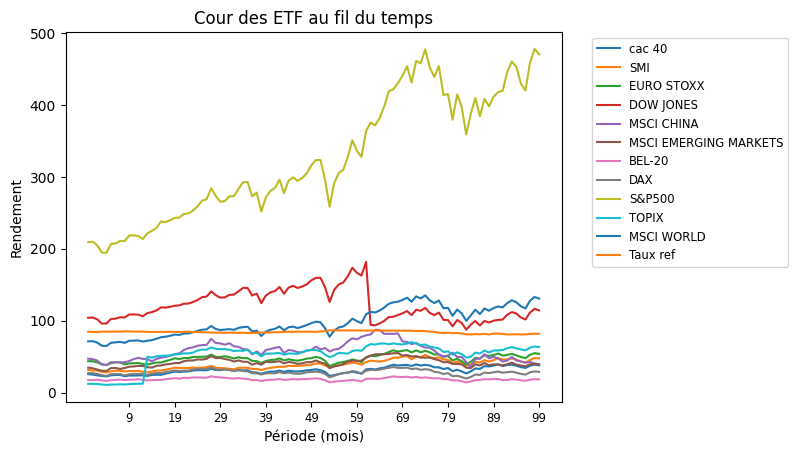

In [4]:
abscisse = [i for i in range(len(data[0]))]
# Boucle sur les ETFs pour tracer les courbes
for k in range(len(data)):
    plt.plot(abscisse, data[k], label=index[k])

# Ajouter des étiquettes et une légende
plt.xlabel('Période (mois)')
plt.ylabel('Rendement')
plt.title('Cour des ETF au fil du temps')
plt.legend()
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1))  

# Inverser l'axe x car les actfs sont rangés du plus récent au plus ancien
plt.gca().invert_xaxis()
custom_legend = [i for i in range(len(abscisse)-1, -1, -1)]  # Inversion des indices
plt.xticks(abscisse[::10][::-1], custom_legend[::10][::-1], fontsize='small')


# Afficher le graphique
plt.show()

### Formule logarithmique du rendement

$$R(t) = \ln\left(\frac{S(t)}{S(t-1)}\right)$$

où :
- $R(t)$ est le rendement à l'instant $t$
- $S(t)$ est le prix de l'actif à l'instant $t$
- $S(t-1)$ est le prix de l'actif à l'instant $t-1$

In [5]:
# Rendement de mes ETF
r = np.array([])

# Boucle sur les ETF
for i in range(len(data)):
    L = []
    
    # Boucle pour calculer les rendements
    for j in range(0, len(data[0]) - 1):
        rendement = np.log(data[i][j] / data[i][j + 1])
        L.append(rendement)
    
    if r.size == 0:
        r = np.array(L)
    else:
        r = np.vstack((r, L))

### Data Visualisation :

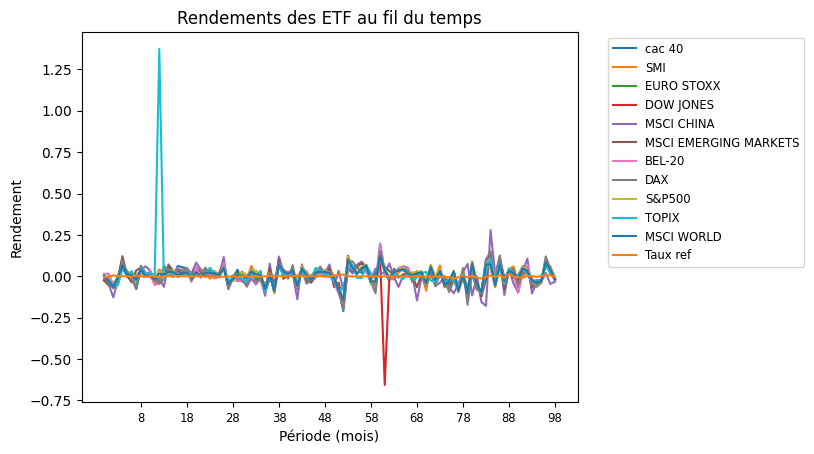

In [6]:
abscisse = [i for i in range(len(r[0]))]

# Boucle sur les ETFs pour tracer les courbes
for k in range(len(data)):
    plt.plot(abscisse, r[k], label=index[k])

# Ajouter des étiquettes et une légende
plt.xlabel('Période (mois)')
plt.ylabel('Rendement')
plt.title('Rendements des ETF au fil du temps')
plt.legend()
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1))  

# Inverser l'axe x car les actfs sont rangés du plus récent au plus ancien
plt.gca().invert_xaxis()
custom_legend = [i for i in range(len(abscisse)-1, -1, -1)]  # Inversion des indices
plt.xticks(abscisse[::10][::-1], custom_legend[::10][::-1], fontsize='small')


# Afficher le graphique
plt.show()

### 1. Maximisation du ratio de Sharpe :

Le Sharpe Ratio est défini comme :


$$\text{{Sharpe Ratio}} = \frac{{\mathbf{R_p} - \mathbf{R_f}}}{{\mathbf{\sigma_p}}}$$

où :

- $R_p$ : rendement du portefeuille,
- $R_f$ : rendement du taux sans risque,
- $\sigma_p$ : volatilité du portefeuille.


In [7]:
def sharpe(weights) : 
    # Rendements du portefeuille
    p = np.dot(weights, r)

    # Volatilité du portefeuille 
    volatility_p = np.std(p)

    # Moyenne de Rendement portefeuille - rendement sans risque
    R = np.mean(p - r[-1])

    # Sharpe ratio annualisé
    sh = (R * 12)/volatility_p
    
    return(-sh)  # On retourne - car on va devoir appliquer la fonction minimize


Meilleurs poids (weights) :
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.46414853e-16
 5.36914034e-16 0.00000000e+00 1.17395127e-15 4.33883818e-16
 8.76003209e-01 1.23996791e-01 0.00000000e+00 0.00000000e+00]


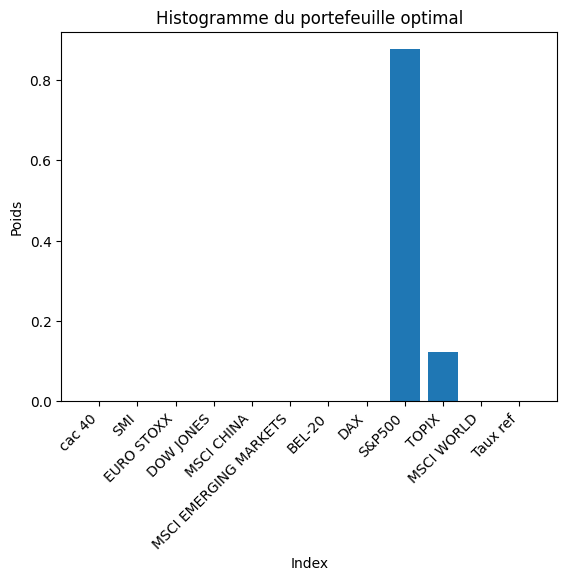

In [8]:
# Recherche du ratio de sharpe max

# Contraintes
contraintes = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Somme des poids égale à 1
bornes = tuple((0, 1) for w in range(len(r)))  # Les poids sont compris entre 0 et 1

# Initialiser les poids
poids_initiaux = np.ones(len(r)) / len(r)

# Utiliser minimize pour trouver les poids optimaux
resultat = minimize(sharpe, poids_initiaux, method='SLSQP', bounds=bornes, constraints=contraintes)

# Afficher le résultat
print("\nMeilleurs poids (weights) :\n", resultat.x)
# Tracer l'histogramme
plt.bar(index, resultat.x)
plt.title('Histogramme du portefeuille optimal')
plt.xlabel('Index')
plt.ylabel('Poids')
plt.xticks(rotation=45, ha='right')  # Ajuster la rotation des étiquettes pour une meilleure lisibilité
plt.show()

**Remarque :** 

Ce genre de résultat n'est pas très surprenant, étant donné le rendement du S&P500 au cours des 15 dernières années. De plus, les ETF sont des produits financiers conçus avec une forme préexistante de 'diversification'. Il est compréhensible que le modèle du ratio de Sharpe voie peu d'intérêt à diversifier ce type de portefeuille.

### Vérification Graphique :

In [9]:
# Génération de 100 vecteurs weights au hasard 
nombre_de_lignes = 10000
nombre_de_colonnes = 12
matrice_de_poids = np.random.rand(nombre_de_lignes, nombre_de_colonnes)

# Rajouter artificiellement du poids autour de s&p 500 et topix pour avoir une meilleure représentation de la zone d'efficience
for i in range (200):
    matrice_de_poids[i][8] += 3
    matrice_de_poids[i][9] += 1
for i in range (200):
    matrice_de_poids[i + 200][8] += 1
    matrice_de_poids[i + 200][9] += 3
for i in range (200):
    matrice_de_poids[i + 400][8] += 2
    matrice_de_poids[i + 400][9] += 2

matrice_de_poids /= np.sum(matrice_de_poids, axis=1, keepdims=True)  # Normaliser les poids pour que la somme soit égale à 1 par ligne


# Création du vecteur rendement et volatilité correspondant 
vecteur_ren = []
vecteur_vol = []
for i in range (1000):
    p = np.dot(matrice_de_poids[i], r)
    mean_r = np.mean(p - r[-1])
    vecteur_ren.append(mean_r)
    vecteur_vol.append(np.std(p))

# Portefeuille optimal
p = np.dot(resultat.x, r)
ren_opt = np.mean(p - r[-1])
vol_opt = np.std(p)

# Portefeuille de référence 
ren_ref = np.mean(r[-1])
vol_ref = np.std(r[-1])

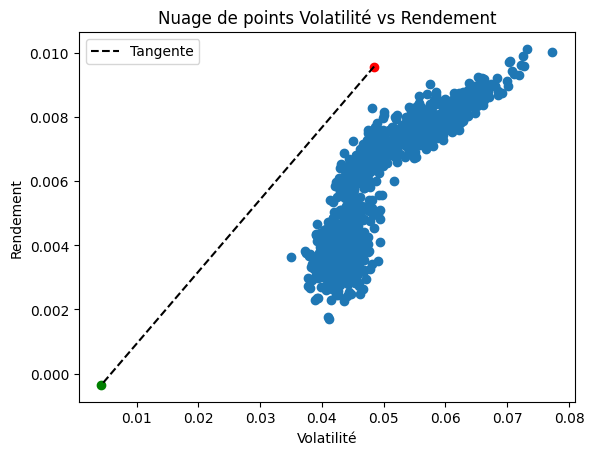

In [10]:
# Nuage de points 
plt.scatter(vecteur_vol, vecteur_ren)
plt.xlabel('Volatilité')
plt.ylabel('Rendement')
plt.title('Nuage de points Volatilité vs Rendement')

# Point portefeuille optimal
plt.scatter(vol_opt, ren_opt, color = 'red')

# Point référence 
plt.scatter(vol_ref, ren_ref, color = 'green')

# Droite tangente à la l'esemble efficient 
plt.plot([vol_opt, vol_ref], [ren_opt, ren_ref], color='black', linestyle='--', label='Tangente')

# Afficher la légende
plt.legend()

**Remarque :**

Sur la courbe, il est difficile de reconnaître l'aspect 'tangente' que l'on est censé avoir en théorie (en raison de la façon dont j'ai choisi mes poids au hasard, avec une région d'efficience mal définie). Cependant, la droite en pointillés se situe clairement au-dessus de l'ensemble des points, ce qui confirme le résultat de mon optimisation.

### Approche probabiliste du ratio de sharpe, significativité:

Nous allons maintenant nous interesser à la significativité statistique de notre estimation.

L'utilisation du ratio de sharpe repose sur plusisieurs hypothèses notamment la distribution normale des rendements ainsi que le caractère IID :

$${r} \sim \mathcal{N}(\nu, \sigma)$$

Cela entraine également une convergence asymptotique Normale de l'estimateur du ratio de Sharpe : 
$$\frac{\text{SR*} - \text{SR}}{\sqrt{\frac{1}{n}\left(1 + {0.5 \text{SR}^2}\right)}} \xrightarrow{\text{d}} \mathcal{N}(0, 1)$$

[Plus de détails mathématiques](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643)


On se retrouve donc avec un intervalle de confiance qui n'a pas de valeur explicite et qui peut être défini pas :

$$IC = \left[ SR* \pm Z_{1-\frac{\alpha}{2}} \sqrt{\frac{1}{n} \left(1 + 0.5 \cdot SR^2\right)} \right]$$

Où $Z_{1-\frac{\alpha}{2}}$ est le quantile d'ordre ${1-\frac{\alpha}{2}}$ de $\mathcal{N}(0, 1)$

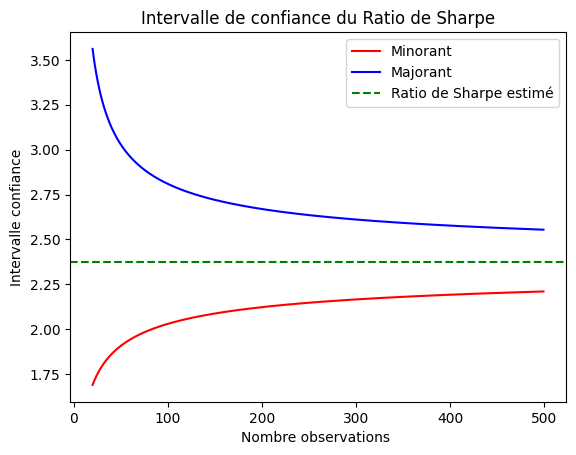

 Intervalle confiance avec 500 observations : 0.3439743884752229
 Intervalle confiance avec 100 observations, comme dans mon exemple : 0.7828980901768658


In [11]:
# Interprétation graphique 
# Choix intervalle confiance : 95%
# Ratio de Sharpe estimé 
ratio_sharpe = -resultat.fun

# Valeur quantile 
z = 1.96

# Fonction minorante
def f_min(x, n):
    return ratio_sharpe - z * np.sqrt((1/n) * (1 + 0.5 * x ** 2))

# Fonction majorante
def f_max(x, n):
    return ratio_sharpe + z * np.sqrt((1/n) * (1 + 0.5 * x ** 2))

# Fonction Ratio Sharpe
def SR(x):
    return x
y_min = []
y_max = []
for k in range (20, 500):
    #y_min
    equation = lambda x: f_min(x, k) - SR(x)
    graine = 1
    solution = fsolve(equation, graine)
    y_min.append(solution[0])

    #y_max
    equation = lambda x: f_max(x, k) - SR(x)
    graine = 1
    solution = fsolve(equation, graine)
    y_max.append(solution[0])
    
n_values = list(range(20, 500))

# Tracé des fonctions
plt.plot(n_values, y_min, color='red', label='Minorant')
plt.plot(n_values, y_max, color='blue', label='Majorant')
plt.axhline(y=ratio_sharpe, color='green', linestyle='--', label='Ratio de Sharpe estimé')
plt.title('Intervalle de confiance du Ratio de Sharpe')
plt.xlabel('Nombre observations ')
plt.ylabel('Intervalle confiance')
plt.legend()
plt.show()

print (" Intervalle confiance avec 500 observations :", y_max[479] - y_min[479])
print (" Intervalle confiance avec 100 observations, comme dans mon exemple :",y_max[79] - y_min[79])

**Remarque :**

Comme on peut le constater, l'intervalle de confiance est relativement large [2,2 ; 3], ce qui rement en question la fiabilité du ratio de sharpe de façon générale, beaucoup d'incertitude, même après 500 observations.
Le ratio de Sharpe est un outil couramment utilisé en gestion de portefeuille. Cependant, sa fiabilité est souvent remise en question : [Plus d'infos à ce sujet](https://youtu.be/fY1rtV6qgoo?si=UGlvzf1Bg5rj58SF)

### 2. Minimisation de la volatilité (Markowitz):

L'objectif de cette seconde méthode va être de fixer un rendement (contrainte), et de minimiser la variance de notre portefeuille sous cette contrainte.

La théorie simple de Markowitz authorise les ventes à découvert cependant dans ce programme nous allons rajouter une contrainte pour avoir un portefeuille sans vente à découvert.

Dans ces conditions la théorie de donne pas de formule explicite, nous allons utiliser la fonction 'minimize' de python pour trouver le portefeuille optimal.

$$\text{variance} : \min \frac{1}{2} \mathbf{W}^T \boldsymbol{\Sigma} \mathbf{W}$$

où $\mathbf{W}$ est le vecteur poids et $\boldsymbol{\Sigma}$  matrice de covariance.

$$\text{contraintes rendement} : \mathbf{R}^T \mathbf{W} > \text{seuil\_fixé}$$

où $\mathbf{R}$ est le vecteur rendements et $\mathbf{W}$ est un vecteur colonne de poids.


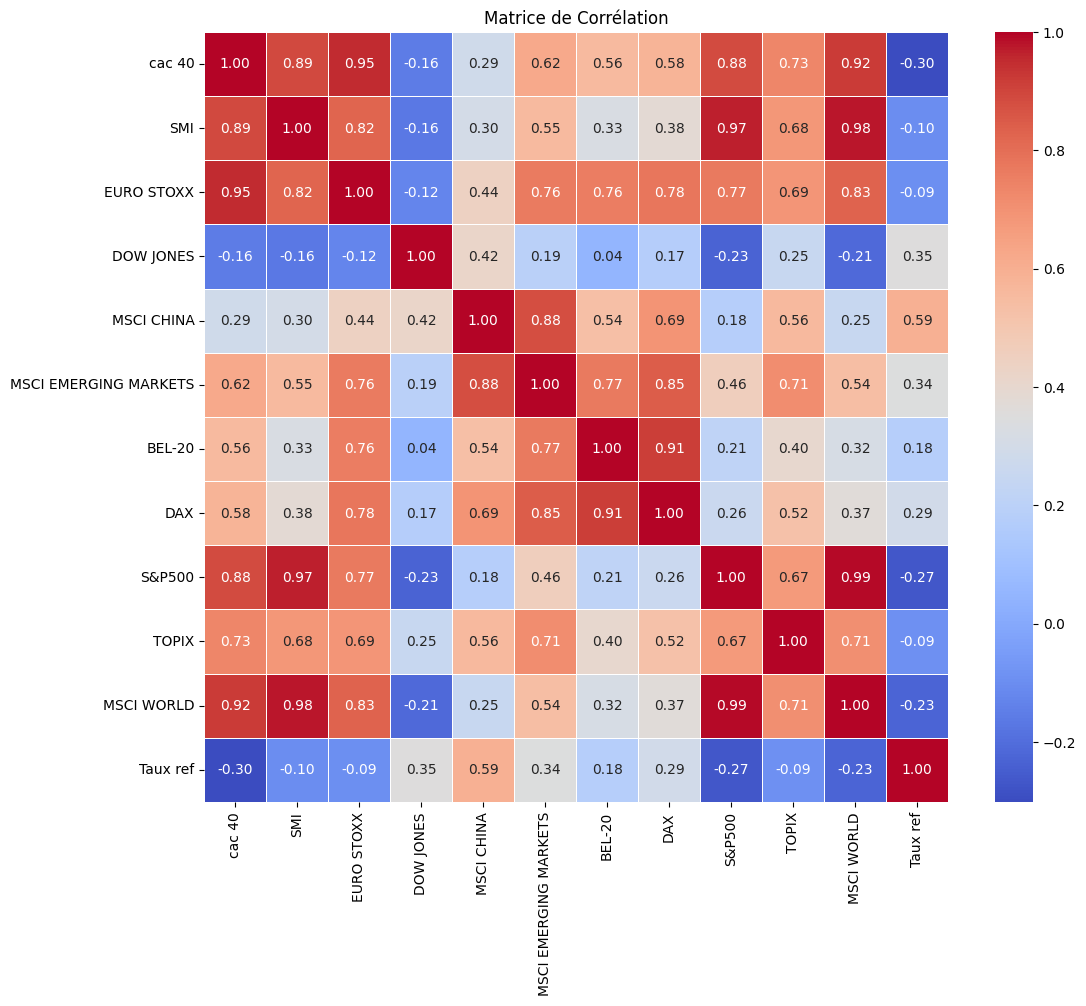

In [12]:
df = pd.DataFrame(data.T, columns = index)

# Calculer la matrice de corrélation
matrice_corr = df.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(matrice_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Matrice de Corrélation")
plt.show()

In [13]:
# Création de notre vecteur rendement, jusqu'à présent, on avait une matrice
vecteur_r = []
for k in range (len(r)):
    vecteur_r.append(np.mean(r[k]))
                
# Création fonction variance
def var(weights):
    var = np.dot(weights, np.dot(matrice_corr, weights))
    return 0.5 * var  # ne sert à rien dans la minimisation mais on va quand même marquer


Meilleurs poids (weights) :
 [4.29221681e-06 2.23743560e-06 2.27744690e-06 1.46530914e-01
 9.85682615e-07 1.11838745e-06 1.74188669e-02 2.45249068e-06
 2.74910334e-01 2.83527481e-01 4.52901346e-06 2.77594511e-01]


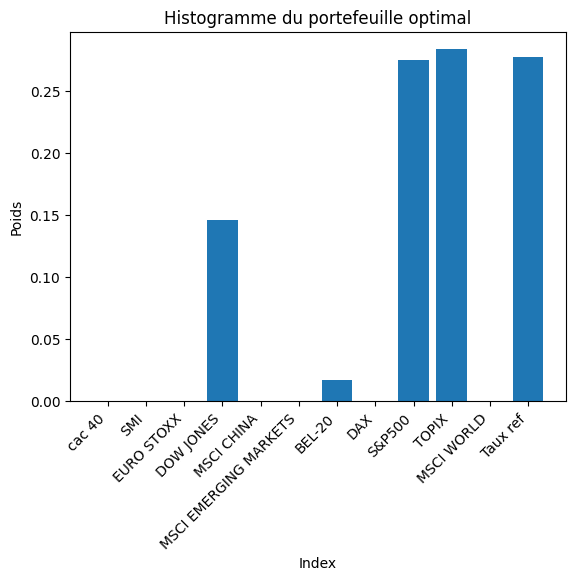

In [15]:
# Rendement fixé 
ren = 0.007  # rappel : rendements sont mensuels

# Recherche de la variance min

# Contraintes
contraintes = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Somme des poids égale à 1
    {'type': 'ineq', 'fun': lambda w: np.dot(w, vecteur_r) - ren}  # Rendement supérieur à ren
]

# Bornes
bornes = tuple((0, 1) for _ in range(len(r)))  # Les poids sont compris entre 0 et 1

# Initialiser les poids
poids_initiaux = [0, 0, 0, 0.2, 0, 0, 0.05, 0, 0.3, 0.2, 0, 2.5]

# Utiliser minimize pour trouver les poids optimaux
resultat = minimize(var, poids_initiaux, method='trust-constr', bounds=bornes, constraints=contraintes)

# Afficher le résultat
print("\nMeilleurs poids (weights) :\n", resultat.x)

# Tracer l'histogramme
plt.bar(index, resultat.x)
plt.title('Histogramme du portefeuille optimal')
plt.xlabel('Index')
plt.ylabel('Poids')
plt.xticks(rotation=45, ha='right')  # Ajuster la rotation des étiquettes pour une meilleure lisibilité
plt.show()

**Remarque :**

Le résultat semble plutôt satisfaisant ; on observe une forte prépondérance de l'obligation (taux ref) à près de 30%. On note également l'apparition de l'indice Dow Jones et une augmentation significative du Topix. Ce résultat n'est pas très surprenant même si la corrélation entre S&P et TOPIX est de 0.67 d'après la matrice de corrélation.

### Vérification graphique :

In [19]:
# Génération de 1000 vecteurs weights au hasard 
nombre_de_lignes = 1000
nombre_de_colonnes = 12
matrice_de_poids = np.random.rand(nombre_de_lignes, nombre_de_colonnes)

# Rajouter artificiellement du poids autour de mon résultat pour avoir une meilleure représentation de la zone d'efficience
for i in range (200):
    matrice_de_poids[i][3] += 1
    matrice_de_poids[i][8] += 1
    matrice_de_poids[i][9] += 1
    matrice_de_poids[i][11] += 1
for i in range (200):
    matrice_de_poids[i + 200][3] += 1
    matrice_de_poids[i + 200][8] += 3
    matrice_de_poids[i + 200][9] += 4
    matrice_de_poids[i + 200][11] += 2
for i in range (200):
    matrice_de_poids[i + 400][3] += 0.5
    matrice_de_poids[i + 400][8] += 2
    matrice_de_poids[i + 400][9] += 2.5
    matrice_de_poids[i + 400][11] += 2.2

matrice_de_poids /= np.sum(matrice_de_poids, axis=1, keepdims=True)  # Normaliser les poids pour que la somme soit égale à 1 par ligne


# Création du vecteur rendement et volatilité correspondant 
vecteur_ren = []
vecteur_vol = []
for i in range (1000):
    p = np.dot(matrice_de_poids[i], r)
    mean_r = np.mean(p - r[-1])
    vecteur_ren.append(mean_r)
    vecteur_vol.append(np.std(p))

# Portefeuille optimal
p = np.dot(resultat.x, r)
ren_opt = np.mean(p - r[-1])
vol_opt = np.std(p)

# Portefeuille de référence 
ren_ref = np.mean(r[-1])
vol_ref = np.std(r[-1])

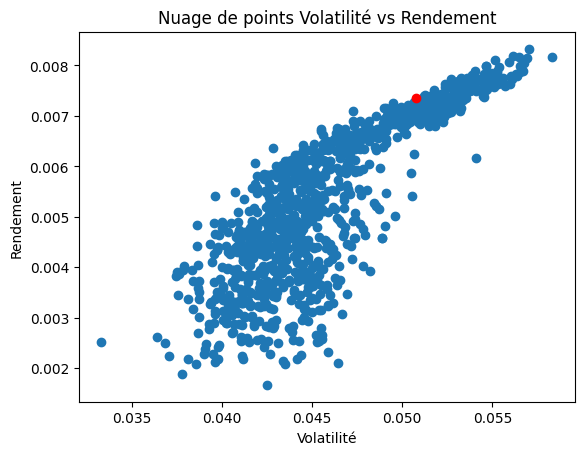

In [20]:
# Nuage de points 
plt.scatter(vecteur_vol, vecteur_ren)
plt.xlabel('Volatilité')
plt.ylabel('Rendement')
plt.title('Nuage de points Volatilité vs Rendement')

# Point portefeuille optimal
plt.scatter(vol_opt, ren_opt, color = 'red')

**Remarque :** 

Dans cette représentation graphique, on distingue mieux la région d'efficience. Le point rouge se situe bien sur sa frontière (approximativement) ce qui confirme le résultat de mon optimisation.